
Dataset: access-drinking-water-stacked.csv
Goal: Clean and prepare all five categories of drinking water access
       (safely managed, basic, limited, unimproved, surface) for analysis.

Notes:
- Keep both positive and negative indicators for the "progress paradox".
- Handle 0s, negative, missing, and scientific notation values carefully.


In [2]:
import pandas as pd
import numpy as np
import os

file_in  = "../data/raw/health/access-drinking-water-stacked.csv"
file_out = "../data/interim/water_access_full_clean.csv"


In [3]:
df = pd.read_csv(file_in)
print("Initial shape:", df.shape)
df.head(10)


Initial shape: (5622, 8)


,Entity,Code,Year,Share of the population using safely managed drinking water services,Share of the population using only basic drinking water services,Share of the population using limited drinking water services,Share of the population using unimproved drinking water services,Share of the population using surface water as a primary source of drinking water
0,Afghanistan,AFG,2000,11.093327,16.348530,3.299203,43.856777,25.402164
1,Afghanistan,AFG,2001,11.105221,16.368359,3.299883,43.843445,25.383093
2,Afghanistan,AFG,2002,12.007733,17.667130,3.607177,42.260395,24.457567
3,Afghanistan,AFG,2003,12.909922,18.965668,3.914072,40.677280,23.533058
4,Afghanistan,AFG,2004,13.818684,20.275747,4.220617,39.086002,22.598950
5,Afghanistan,AFG,2005,14.733853,21.597374,4.526453,37.486350,21.655968
6,Afghanistan,AFG,2006,15.648427,22.918694,4.831402,35.886433,20.715044
7,Afghanistan,AFG,2007,16.562523,24.521150,4.854220,34.286083,19.776024
8,Afghanistan,AFG,2008,17.476011,26.156599,4.842827,32.685455,18.839108
9,Afghanistan,AFG,2009,18.388884,27.824879,4.797374,31.084550,17.904312


In [4]:
df = df.rename(columns={
    'Entity': 'country',
    'Code': 'iso_code',
    'Year': 'year',
    'Share of the population using safely managed drinking water services': 'water_safely_managed',
    'Share of the population using only basic drinking water services': 'water_basic',
    'Share of the population using limited drinking water services': 'water_limited',
    'Share of the population using unimproved drinking water services': 'water_unimproved',
    'Share of the population using surface water as a primary source of drinking water': 'water_surface'
})

# keep relevant columns only
df = df[['iso_code', 'country', 'year',
         'water_safely_managed', 'water_basic',
         'water_limited', 'water_unimproved', 'water_surface']]

# drop regional aggregates
df = df[df['iso_code'].notna()]
df = df[df['year'].between(1990, 2022)]
print("After filtering:", df.shape)


After filtering: (5116, 8)


In [5]:
num_cols = ['water_safely_managed', 'water_basic', 'water_limited', 'water_unimproved', 'water_surface']

for col in num_cols:
    # convert to numeric safely
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # remove invalid negatives
    df.loc[df[col] < 0, col] = np.nan

    # convert very tiny scientific noise values (<0.0001) to zero
    df.loc[(df[col] > 0) & (df[col] < 1e-4), col] = 0


In [6]:
# flag rows where all values ~0 or missing (likely invalid)
invalid_rows = df[num_cols].sum(axis=1) < 1
print("Rows flagged as invalid:", invalid_rows.sum())

# mark them as NaN
df.loc[invalid_rows, num_cols] = np.nan


Rows flagged as invalid: 251


In [7]:
# total with at least basic service
df['water_access_total'] = df['water_safely_managed'].fillna(0) + df['water_basic'].fillna(0)

# total with sub-basic (limited/unimproved/surface)
df['water_inadequate_total'] = (
    df['water_limited'].fillna(0)
    + df['water_unimproved'].fillna(0)
    + df['water_surface'].fillna(0)
)


,water_safely_managed,water_basic,water_limited,water_unimproved,water_surface
count,3370.000000,3370.000000,4865.000000,4865.000000,4771.000000
mean,69.539729,20.079580,3.642281,6.702848,3.328980
std,30.655541,19.582149,5.955147,9.315960,6.183552
min,1.430447,0.000000,0.000000,0.000000,0.000000
25%,45.977272,2.175000,0.000000,0.494711,0.000000
50%,81.299322,16.139160,0.759896,2.582409,0.171040
75%,96.950318,36.063705,4.994160,9.032271,3.840049
max,100.000000,91.141950,37.497322,54.743385,49.424465


 Countries/years with totals >100%: 0


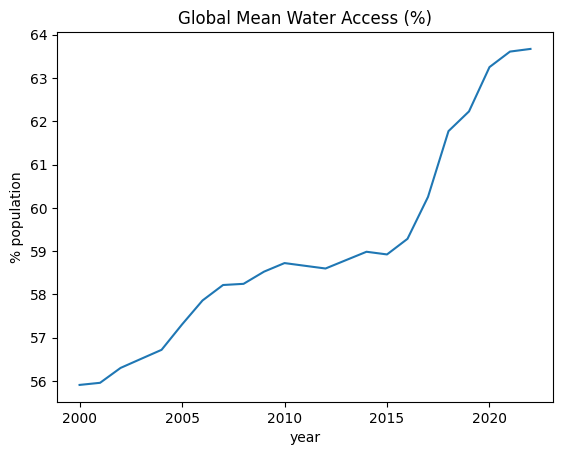

In [9]:
# 1. basic descriptive stats
display(df.describe()[num_cols])

# 2. ensure totals don't exceed 100%
over_100 = (df[num_cols].sum(axis=1) > 101).sum()
print(f" Countries/years with totals >100%: {over_100}")

# 3. visual sanity check (optional)
import matplotlib.pyplot as plt
df.groupby('year')['water_access_total'].mean().plot(title='Global Mean Water Access (%)')
plt.ylabel('% population')
plt.show()


In [10]:
df = df.sort_values(['iso_code', 'year']).reset_index(drop=True)

os.makedirs("../data/interim/", exist_ok=True)
df.to_csv(file_out, index=False)
print(f" Cleaned file saved → {file_out}")


 Cleaned file saved → ../data/interim/water_access_full_clean.csv


In [11]:
summary = pd.DataFrame({
    'column': num_cols + ['water_access_total', 'water_inadequate_total'],
    'missing_%': df[num_cols + ['water_access_total', 'water_inadequate_total']].isna().mean().round(3) * 100,
    'min': df[num_cols + ['water_access_total', 'water_inadequate_total']].min().round(2),
    'max': df[num_cols + ['water_access_total', 'water_inadequate_total']].max().round(2)
})
display(summary)


,column,missing_%,min,max
water_safely_managed,water_safely_managed,34.1,1.43,100.00
water_basic,water_basic,34.1,0.00,91.14
water_limited,water_limited,4.9,0.00,37.50
water_unimproved,water_unimproved,4.9,0.00,54.74
water_surface,water_surface,6.7,0.00,49.42
water_access_total,water_access_total,0.0,0.00,100.00
water_inadequate_total,water_inadequate_total,0.0,0.00,81.32


In [12]:
# sort by country and year
df = df.sort_values(['iso_code', 'year']).reset_index(drop=True)

cols_to_interp = [
    'water_safely_managed', 'water_basic',
    'water_limited', 'water_unimproved', 'water_surface'
]

print("Missing values before interpolation (%):")
print((df[cols_to_interp].isna().mean() * 100).round(2))

# linear interpolation within each country
df[cols_to_interp] = (
    df.groupby('iso_code', group_keys=False)[cols_to_interp]
      .transform(lambda g: g.interpolate(method='linear', limit_direction='both'))
)

print("\n Missing values after interpolation (%):")
print((df[cols_to_interp].isna().mean() * 100).round(2))


Missing values before interpolation (%):
water_safely_managed    34.13
water_basic             34.13
water_limited            4.91
water_unimproved         4.91
water_surface            6.74
dtype: float64

 Missing values after interpolation (%):
water_safely_managed    34.13
water_basic             34.13
water_limited            3.60
water_unimproved         3.60
water_surface            3.60
dtype: float64


In [14]:
df['water_access_total'] = df['water_safely_managed'].fillna(0) + df['water_basic'].fillna(0)
df['water_inadequate_total'] = (
    df['water_limited'].fillna(0)
    + df['water_unimproved'].fillna(0)
    + df['water_surface'].fillna(0)
)


In [15]:
missing_by_country = (
    df.groupby('iso_code')[cols_to_interp]
      .apply(lambda x: x.isna().mean() * 100)
)

heavy_missing = missing_by_country.mean(axis=1).sort_values(ascending=False)
print("Top 10 countries with highest remaining missingness (%):")
display(heavy_missing.head(10))


Top 10 countries with highest remaining missingness (%):


iso_code
ARE    100.0
BRN    100.0
BMU    100.0
AUS    100.0
FRO    100.0
GRL    100.0
COK    100.0
MUS    100.0
BWA     40.0
CHN     40.0
dtype: float64

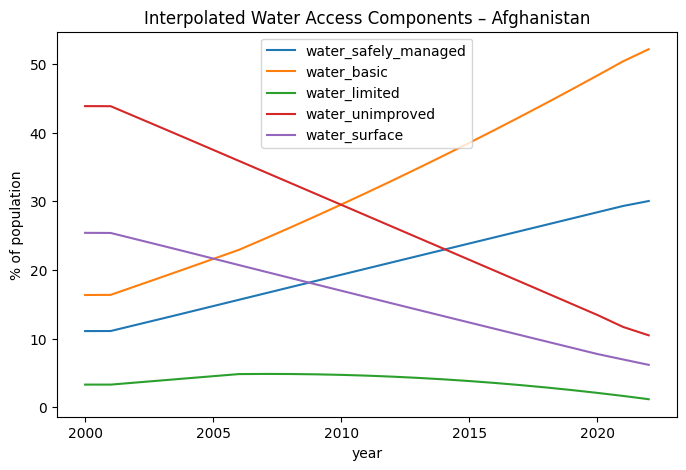